In [1]:
%matplotlib inline  

import pandas as pd
import numpy as np
import pandas_highcharts.core
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot 

#import datetime 
from datetime import datetime, date, timedelta

from isoweek import Week

import os

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "IMAM.settings")

from django.conf import settings
from home.management.commands.load_data import rename_cols, assign_state_lga_num

import django
django.setup()

from home.models import Stock, Site, Second_admin

In [2]:
engine = create_engine(
    'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{NAME}'.format(**settings.DATABASES['default']))
df = pd.read_sql_query("select * from stock;", con=engine)

In [3]:
wh = pd.read_sql_query("select * from warehouse;", con=engine)

In [52]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,year,...,rutf_used_sachet,rutf_bal_carton,rutf_bal_sachet,f75_bal_carton,f75_bal_sachet,f100_bal_carton,f100_bal_sachet,type,lga_num,state_num
0,472692997,dba88bc7-a40f-4ea2-9d17-d6daaa6a62d0,+2347061326033,Bishir Dahiru.,,2015210001,2017-05-22 19:07:22.867417+02:00,2017-05-22 19:12:58.645868+02:00,20,2017,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,SC,2015.0,20
1,472703506,d745fc85-ffae-4cfc-935c-267a16bd7bca,+2348067698638,Nafiu Bello.,,3605110051,2017-05-22 19:08:37.044179+02:00,2017-05-22 19:11:34.060101+02:00,17,2017,...,NaN,NaN,NaN,0.0,34.0,0.0,0.0,SC,3605.0,36
2,472677424,33f41b70-50d8-4b0b-a74f-1972563e4b38,+2348095420283,Nuhu Mamman Jaramas.,,827110015,2017-05-22 18:59:26.366083+02:00,2017-05-22 19:10:38.896902+02:00,17,2017,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,OTP,827.0,8
3,472699003,164d2fb8-65b4-4603-80b4-29a14a1acaa1,+2347069740933,Ibrahim Abdullahi.,,3605110063,2017-05-22 19:07:58.525011+02:00,2017-05-22 19:10:25.122597+02:00,20,2017,...,51.0,6.0,61.0,NaN,NaN,NaN,NaN,OTP,3605.0,36
4,472677980,a4c63a1a-51f8-4aac-b690-dee70513aad3,+2348099502813,Ibrahim Liman.,,1719110023,2017-05-22 19:04:39.863741+02:00,2017-05-22 19:08:51.141754+02:00,17,2017,...,115.0,5.0,0.0,NaN,NaN,NaN,NaN,OTP,1719.0,17


In [191]:
# Missing data for weeknum
print sorted(df.weeknum.unique())[0:5]
#df.weeknum.value_counts()

# Still week number 53 is included.
# it is deleted below in data cleaning

[1, 2, 3, 4, 5]


In [ ]:
# Make sure that supervision staff can submit reports for sites. 

In [2]:
# Do not need to import data when it is directly available from postgres

# df = pd.ExcelFile('/home/robert/Downloads/sto.xlsx').parse('Runs')


In [5]:
# rename_cols(df)

In [32]:
df.keys()

Index([u'index', u'contact_uuid', u'urn', u'name', u'groups', u'siteid',
       u'first_seen', u'last_seen', u'weeknum', u'year', u'rutf_in',
       u'rutf_used_carton', u'rutf_used_sachet', u'rutf_bal_carton',
       u'rutf_bal_sachet', u'f75_bal_carton', u'f75_bal_sachet',
       u'f100_bal_carton', u'f100_bal_sachet', u'type'],
      dtype='object')

In [62]:
df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')
df['weeknum'] = pd.to_numeric(df.weeknum, errors='coerce')
df['rutf_bal_carton'] = pd.to_numeric(df.rutf_bal_carton, errors='coerce')
df['rutf_bal_sachet'] = pd.to_numeric(df.rutf_bal_sachet, errors='coerce')

df = df.query('siteid==siteid').query('0<siteid<3999990999')
# 2015 had 53 weeks
# 2016 had 52 weeks - current data is only for weeknumbers from 22-2016 to present
df = df.query('weeknum==weeknum').query('0.99<weeknum<53')
df = df.query('rutf_bal_carton==rutf_bal_carton').query('0<=rutf_bal_carton<9999')
df = df.query('rutf_bal_sachet==rutf_bal_sachet').query('0<=rutf_bal_sachet<9999')

df['siteid'] = df.siteid.astype('int')
df['weeknum'] = df.weeknum.astype('int')
df['rutf_bal_carton'] = df.rutf_bal_carton.astype('int')
df['rutf_bal_sachet'] = df.rutf_bal_sachet.astype('int')

In [4]:
len(df)

28395

In [194]:
# Drop unvalidated data
# df = df.query('confirm=="Yes"')

# all unvalidated data are not imported

In [63]:
# all duplicates should have been dropped in importation
# check if this is correct - did we forget type in importation? 

# Before filter - Sort data
df = df.sort_values(by='last_seen', ascending = False)
df = df.drop_duplicates(['siteid', 'weeknum', 'type','year'], keep ='first')

len(df)

28537

In [64]:
df['year_weeknum'] = zip(df['year'], df['weeknum'])

#the variable 'iso_year_weeknum' is an isoweek object
df['iso_year_weeknum'] = df['year_weeknum'].map(lambda x: Week(x[0], x[1]))

year, week, _ = date.today().isocalendar()
current_week = Week(year, week)

# Number of weeks from current week until report week (weeknum)
df['since_x_weeks'] = df['iso_year_weeknum'].map(lambda x: current_week - x)

In [65]:
df = df.query('not (weeknum < 22 & year <=2016)')
df = df.query('not (weeknum > %s & year ==%s)' % (week, year)) 
df = df.query('year >= 2016')

In [66]:
# Year is added and corrected in importation
df['year'].value_counts()

2017    14036
2016    13922
Name: year, dtype: int64

In [166]:
# are year_weeknum and iso_year_weeknum the same? 
#df.plot.scatter('year_weeknum', 'iso_year_weeknum')

print (df['year_weeknum']) == (df['iso_year_weeknum'])

#First is tuple, second is isocalendar object
print type(df['year_weeknum'])
print type(df['iso_year_weeknum'])

13727    True
25629    True
6626     True
7940     True
7942     True
1163     True
7972     True
1178     True
24856    True
1204     True
1260     True
1271     True
7372     True
1275     True
8269     True
1738     True
6440     True
398      True
1668     True
4973     True
6128     True
6944     True
4937     True
25623    True
6911     True
4930     True
651      True
428      True
6865     True
233      True
         ... 
15576    True
15621    True
13711    True
20559    True
13411    True
19925    True
19921    True
19913    True
15923    True
19912    True
13650    True
15631    True
15629    True
13709    True
20082    True
15058    True
15074    True
15071    True
15069    True
18511    True
16428    True
20024    True
19922    True
12670    True
16427    True
10879    True
17124    True
13717    True
26133    True
17156    True
dtype: bool
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


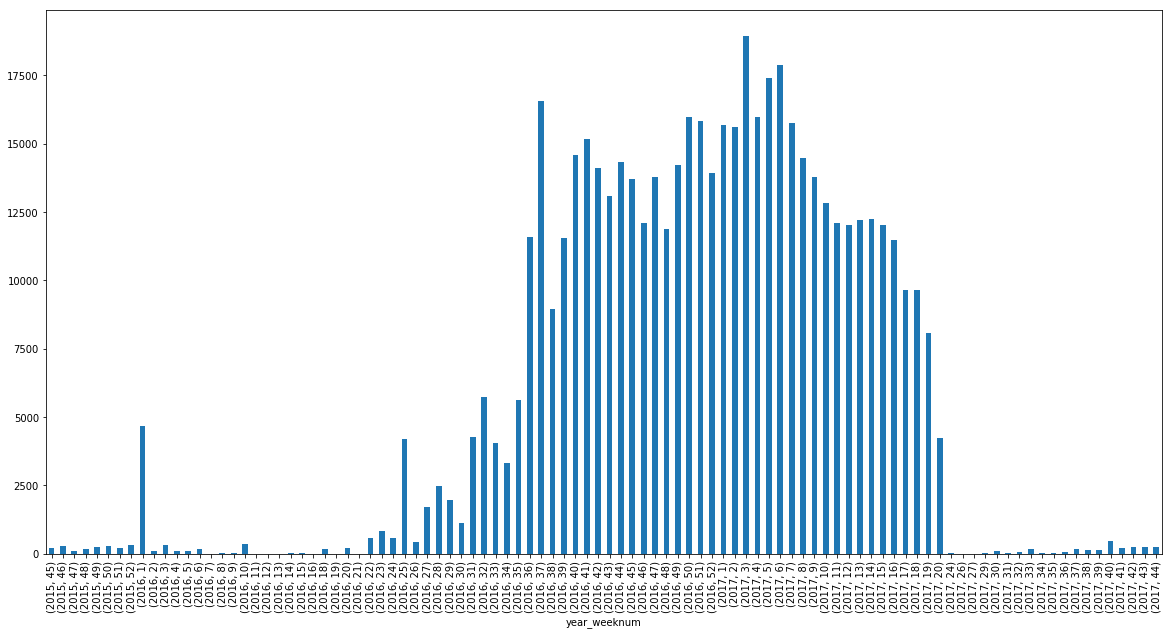

In [185]:
# review year_weeknum in table sorted by date

# all implementation level RUTF stock balance by week
stock_by_week = df['rutf_bal_carton'].groupby(df['year_weeknum']).sum().plot(kind = 'bar', figsize=(20,10))


# value counts is not easily sortable by date
#(df['year_weeknum'].value_counts().plot(kind = 'bar')

# sort data
#df = df.sort_values(by=['iso_year_weeknum'])    
    
#df['year_weeknum'].value_counts().plot(kind = 'bar')
# value counts always presents data as distribution sorted by number of counts

In [183]:
# For state and LGA queries
# Use LGA database
assign_state_lga_num(df)
df.lga_num.unique()


array(['3503', '3609', '812', '821', '513', '2010', '1712', '2109', '2004',
       '1940', '2112', '813', '3605', '816', '1823', '1921', '1905', '819',
       '208', '818', '2018', '218', '3313', '3513', '2011', '2034', '3317',
       '1719', '2104', '1805', '804', '2016', '1936', '3517', '212',
       '3504', '3514', '1704', '221', '3501', '814', '2027', '806', '3602',
       '2106', '802', '3301', '3319', '202', '3611', '1727', '805', '1710',
       '2113', '3305', '1714', '3308', '2026', '217', '3509', '3505',
       '2118', '3508', '2119', '825', '1944', '2115', '3510', '1606',
       '2001', '2105', '3502', '3304', '1724', '1801', '3511', '203',
       '1928', '2003', '512', '3306', '213', '1604', '827', '1716', '2117',
       '807', '3321', '2033', '220', '1703', '2015', '2108', '2114', '201',
       '206', '2103', '3607', '209', '210', '504', '3507', '1702', '809',
       '215', '2005', '1818', '2007', '1717', '3512', '3506', '3516',
       '207', '2111', '219', '2024', '3603', 

In [150]:
# LGA level stocks must use LGA stock df

# Calculate median stock use over time. 
stock_by_week = df.query('state_num==2')['rutf_bal_carton'].groupby(df['year_weeknum'])\
        .sum().plot(kind = 'bar', figsize=(20,10))

TypeError: Empty 'DataFrame': no numeric data to plot

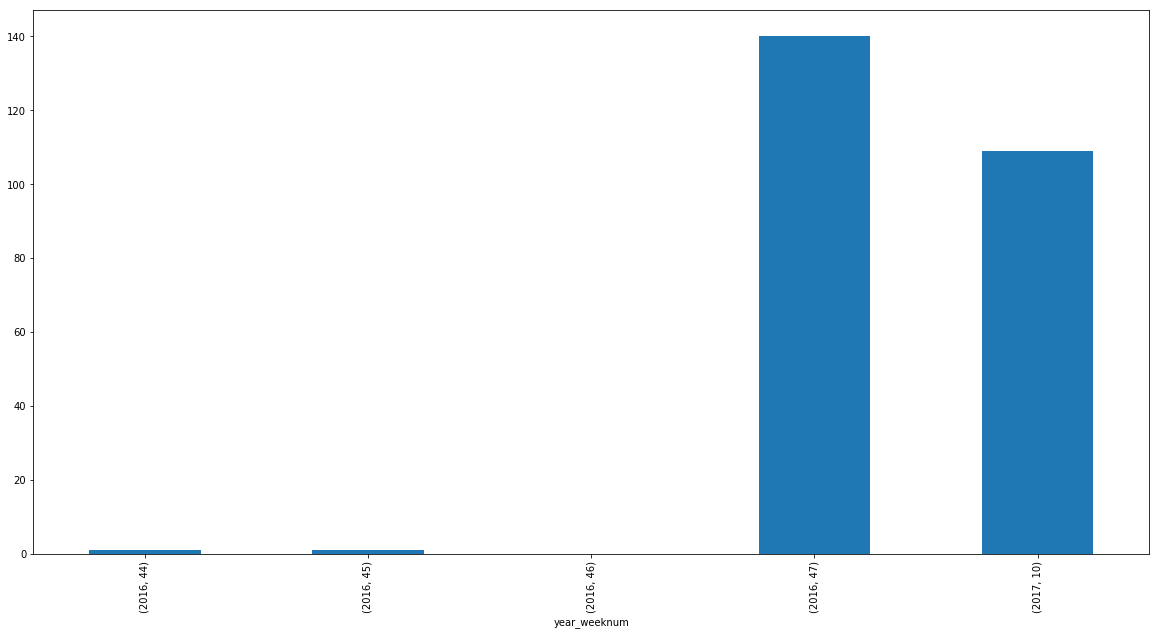

In [206]:
# For site level queries
stock_by_week = df.query('siteid==211110029 & type=="OTP"')['rutf_bal_carton'].groupby(df['year_weeknum']).sum().plot(kind = 'bar', figsize=(20,10))

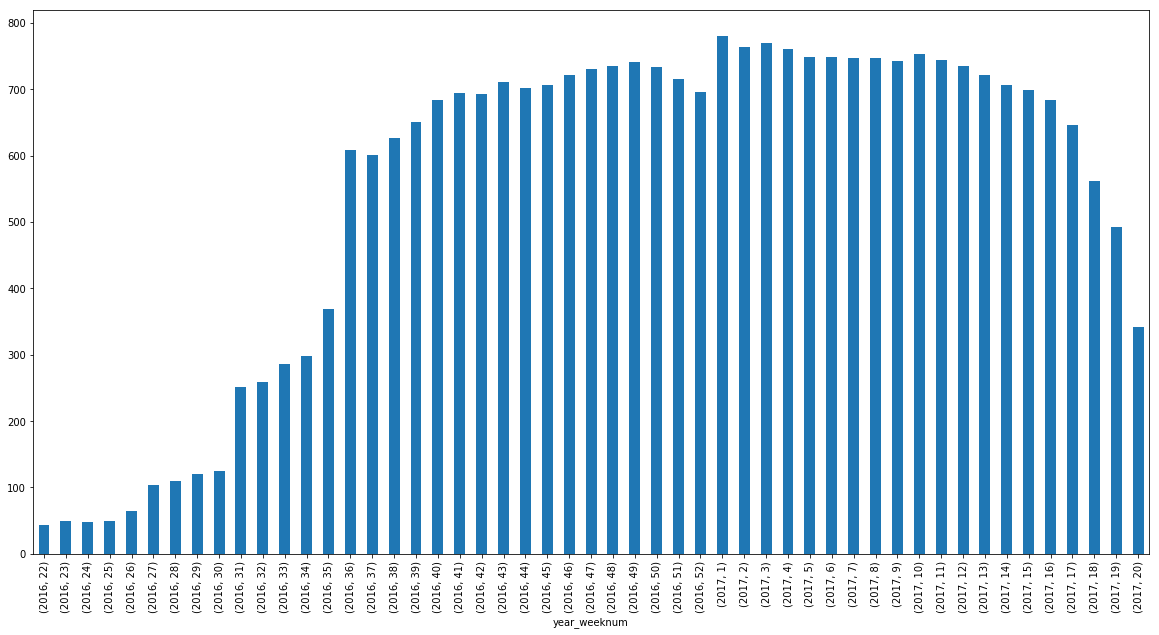

In [9]:
# sort data
df = df.sort_values(by=['since_x_weeks'])    

# Plot count of reports over year_weeknum
# Presents the counts of data received
report_counts = df['index'].groupby(df['year_weeknum']).count().plot(kind = 'bar', figsize=(20,10))

# significant missing data from week 50, 51, 52
# appears these data are incorrectly assigned to year 2017
# are these incorrect 2017 data all reported after weeknumber 8 in year 2017? 

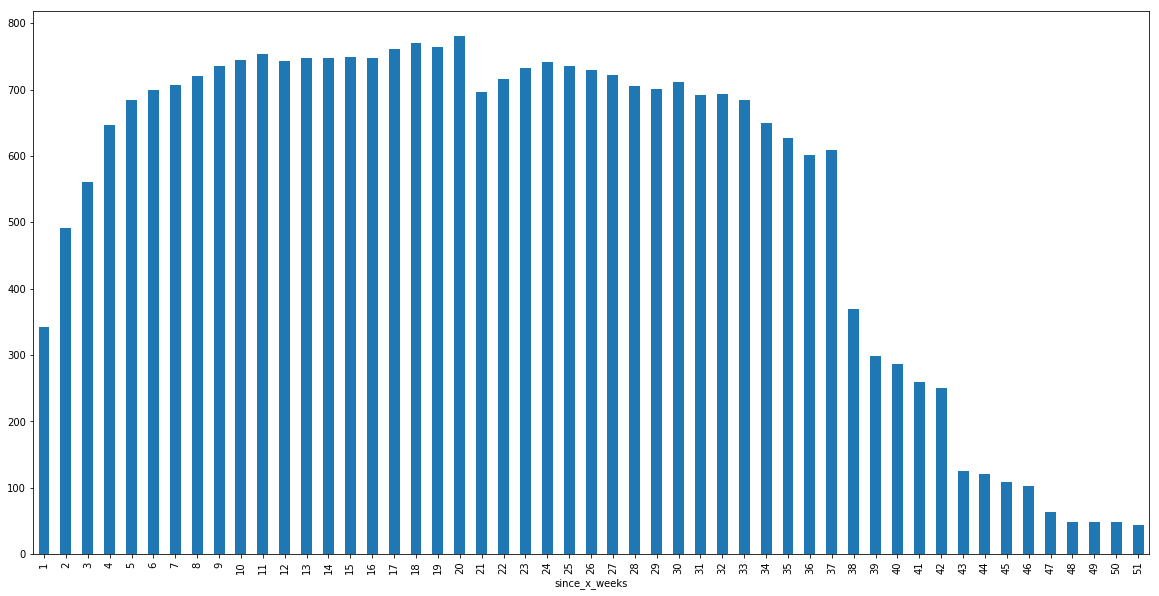

In [10]:
df['index'].groupby(df['since_x_weeks']).count().plot(kind = 'bar', figsize=(20,10))



In [11]:
# What is the median stock consumption over past 8 weeks

df['since_x_weeks'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [43]:
df['rutf_out'] = df['rutf_used_carton'] + (df['rutf_used_sachet'] /150)
# we do not have utilization for f75 or f100
# We only have balance
# can we estimate needs ? it is difficult because some sites use RUTF and others F75 F100
# should change the report in SC to report in, out, balance of RUTF F75 & F100

max_since_x_weeks = df['since_x_weeks'].max()


result = {
    'rutf_out': [],
    'isoweek': [],
}

for i in sorted(df['since_x_weeks'].unique()):
    if i > (max_since_x_weeks - 7):
        break
    # XXX do we need to break before the end because we move on a window of * weeks?
    result['rutf_out'].append(df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['rutf_out'].median())
    result['isoweek'].append(df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['iso_year_weeknum'].max())

median_usage = pd.DataFrame(result)
median_usage
# print result


,isoweek,rutf_out
0,"(2017, 20)",5.986667
1,"(2017, 19)",5.720000
2,"(2017, 18)",5.460000
3,"(2017, 17)",5.246667
4,"(2017, 16)",5.223333
5,"(2017, 15)",5.166667
6,"(2017, 14)",5.180000
7,"(2017, 13)",5.246667
8,"(2017, 12)",5.393333
9,"(2017, 11)",5.583333


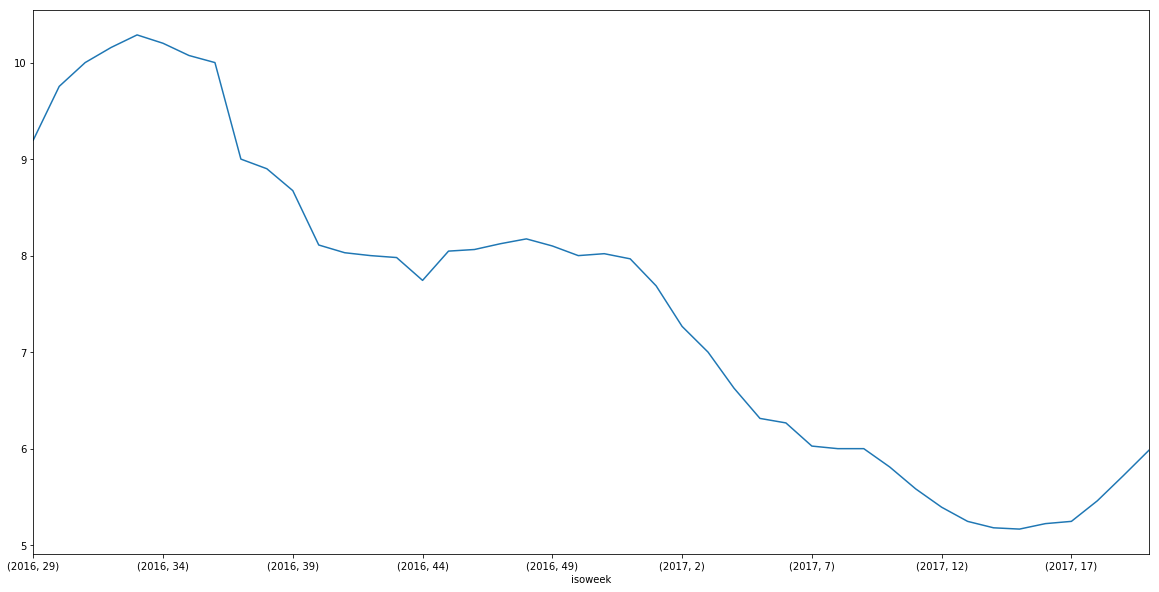

In [44]:
median_usage.groupby(['isoweek'])['rutf_out'].sum().plot(figsize=(20,10))

In [11]:
# Quantity of RUTF in last (most recent) stock report

sorted(df.query('year==2017').sort_values(by='weeknum', ascending = False)\
       .drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 60,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 71,
 74,
 77,
 79,
 81,
 84,
 85,
 86,
 91,
 94,
 95,
 96,
 103,
 109,
 112,
 118,
 123,
 127,
 130,
 133,
 140,
 150,
 174,
 175,
 180,
 181,
 183,
 258,
 269,
 499]

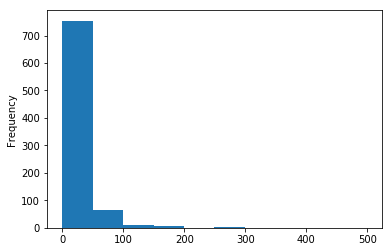

In [56]:
# most recent stock report for sites
df.query('year==2017').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'],\
                keep ='last')['rutf_bal_carton'].plot.hist()

In [33]:
#  Current stock report rate 
stock_report_rate = df.query('since_x_weeks>0').query('since_x_weeks<=8').groupby(df['siteid'])[
    'weeknum'].count().map(lambda x: (x / 8.) * 100).mean()

stock_report_rate

81.082887700534755

In [ ]:
# list of stock out sites in coverage area
# What is the most recent report
# if it is a stock out - add to list - State name, LGA name, Site Name SiteID Weeknum, RUTF

In [57]:
# most recent stock report for sites
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_carton']
print df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

2853    24
Name: rutf_bal_carton, dtype: int64
2853    43
Name: rutf_bal_sachet, dtype: int64


In [58]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['rutf_bal_sachet']

2853    43
Name: rutf_bal_sachet, dtype: int64

In [59]:
 df.query('year==2017').query('siteid==3613110051').sort_values(by='weeknum', ascending = False).drop_duplicates(['siteid'], keep ='last')['weeknum']

2853    1
Name: weeknum, dtype: int64

In [60]:
import datetime as datetime

In [61]:
print datetime.datetime.now().strftime('Weekly reminders sent at %d %b %Y %-H:%M:%S')

Weekly reminders sent at 19 May 2017 17:57:35


In [62]:
print datetime.datetime.now().strftime('Weekly reminders sent at %c')
#print datetime.datetime.now()

Weekly reminders sent at Fri May 19 17:57:37 2017


In [88]:
wh.siteid.unique()

array([      2010,       1609,       2003,       3317,       1727,
             1928,        203,       1704,         35,         18,
             3613,       3510,        805,       1719,        207,
             2007,       1818,       2106,       1604,       3512,
             1823,         19,       3501,         21,       3304,
             2001,  827110013,       1936,       1905,        807,
               16,       2027,       3301,       2112,       3306,
             1944,       3313,       2018,        202,        211,
              217,       1921,       3305,        212,       1940,
             2108,       2026,        802,       2033,       2119,
              201,       2016,       2034,       2118,        208,
             1702,        220,        216,       2011,       1606,
             2004,       3308,        204,       3509,          8,
              221,       1717,       2113,       1724,       3321,
              213,       3319,          2,       2024,        

In [67]:
# working lga id 2003

wh_sites = df.query("lga_num==2003").groupby(['siteid', 'weeknum']).sum().reset_index()
wh_sites

,siteid,weeknum,index,year,rutf_in,rutf_used_carton,rutf_used_sachet,rutf_bal_carton,rutf_bal_sachet,f75_bal_carton,f75_bal_sachet,f100_bal_carton,f100_bal_sachet,lga_num,state_num,since_x_weeks
0,2003110011,1,416158064,2017,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,20
1,2003110011,3,420970657,2017,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,18
2,2003110011,4,423378604,2017,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,17
3,2003110011,5,423888141,2017,85.0,33.0,44.0,51,106,NaN,NaN,NaN,NaN,2003.0,20,16
4,2003110011,6,428597118,2017,0.0,38.0,106.0,13,0,NaN,NaN,NaN,NaN,2003.0,20,15
5,2003110011,7,430005843,2017,0.0,8.0,0.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,14
6,2003110011,8,440472760,2017,50.0,34.0,105.0,15,45,NaN,NaN,NaN,NaN,2003.0,20,13
7,2003110011,9,440473685,2017,0.0,15.0,45.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,12
8,2003110011,10,451686351,2017,0.0,0.0,0.0,0,0,NaN,NaN,NaN,NaN,2003.0,20,11
9,2003110011,12,457495487,2017,50.0,30.0,55.0,19,95,NaN,NaN,NaN,NaN,2003.0,20,9


In [69]:
df.query("lga_num==2003")['siteid'].unique()

[2003110033, 2003110011, 2003110054, 2003110030, 2003110065]

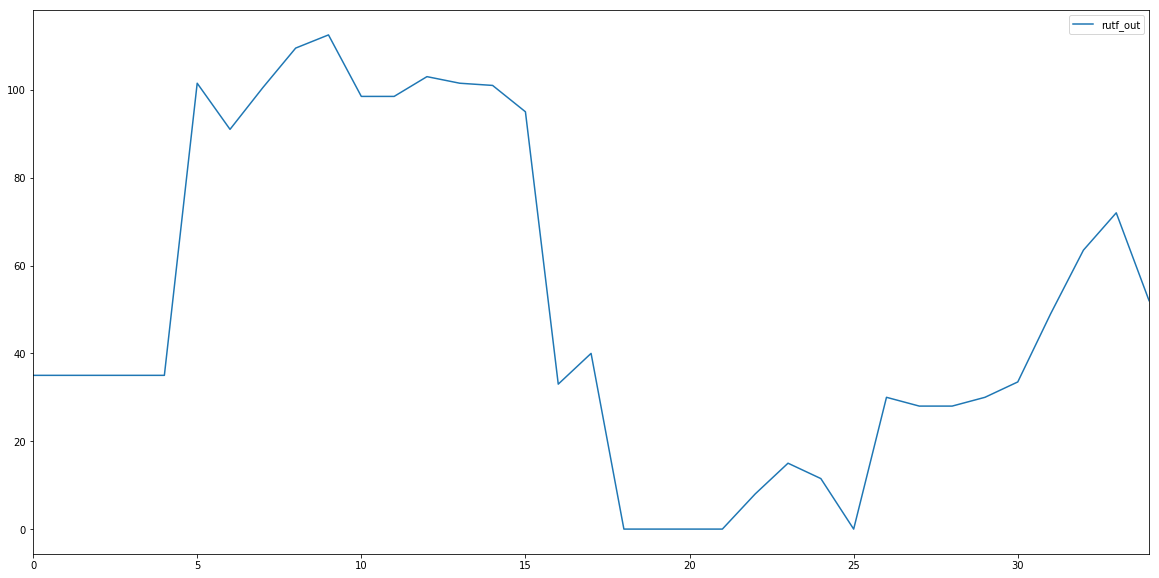

In [77]:
# we do not have utilization for f75 or f100
# We only have balance
# can we estimate needs ? it is difficult because some sites use RUTF and others F75 F100
# should change the report in SC to report in, out, balance of RUTF F75 & F100



result = {}

for siteid in df.query("lga_num==2003")['siteid'].unique():
    site_df = df.query('siteid==%s' % siteid)
    max_since_x_weeks = site_df['since_x_weeks'].max()

    for i in sorted(site_df['since_x_weeks'].unique()):
        if i > (max_since_x_weeks - 7):
            break
        
        isoweek = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['iso_year_weeknum'].max()
        rutf_out = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['rutf_used_carton'].median()
        
        if isoweek not in result:
            result[isoweek] = rutf_out
        else:
            result[isoweek] = result[isoweek] + rutf_out

            
# only to create the DF
dict_for_df = {
    "isoweek": [],
    "rutf_out": [],
}

for key, value in sorted(result.items(), key=lambda x: x[0]):
    dict_for_df['isoweek'].append(key)
    dict_for_df['rutf_out'].append(value)
    
warehouse_median_usage = pd.DataFrame(dict_for_df)
warehouse_median_usage.plot(figsize=(20,10))
# result

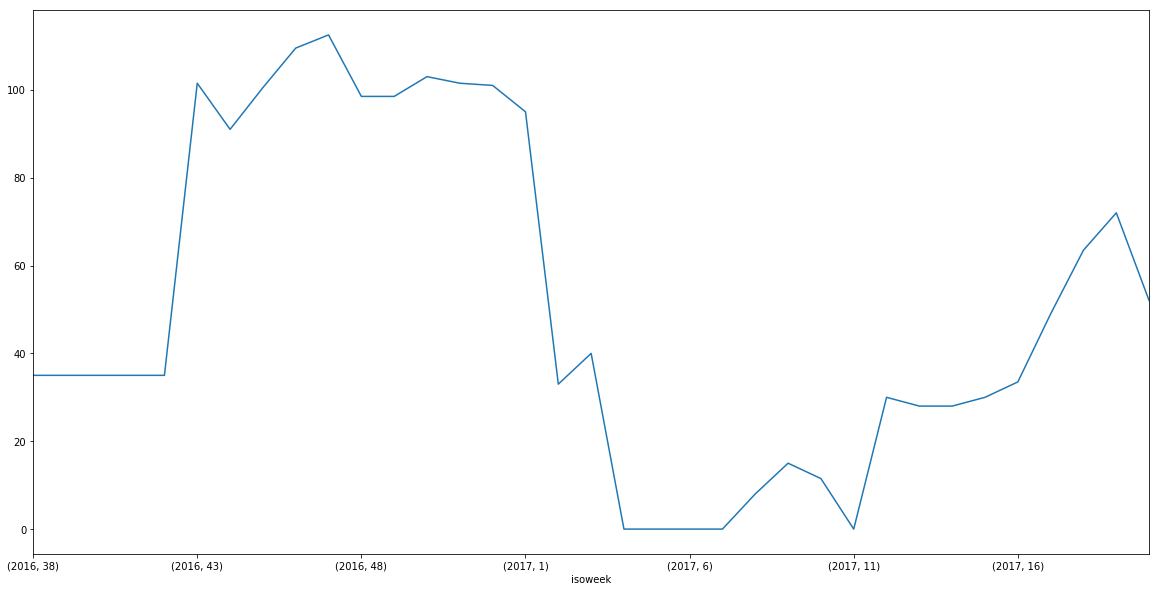

In [78]:
warehouse_median_usage.groupby(['isoweek'])['rutf_out'].sum().plot(figsize=(20,10))

In [84]:
# state query id 20

wh_sites = df.query("state_num==20").query("siteid>200000000").groupby(['siteid', 'weeknum']).sum().reset_index()
wh_sites['siteid'].unique()
# remove LGA
# .query("siteid>200000000")

array([2001110004, 2001110024, 2001110030, 2001110059, 2001110069,
       2003110011, 2003110030, 2003110033, 2003110054, 2003110065,
       2004110002, 2004110006, 2004110009, 2004110010, 2004110013,
       2004110016, 2004110017, 2004110019, 2004110020, 2004110024,
       2004110027, 2004110034, 2004110035, 2004110042, 2004210001,
       2005110001, 2005110025, 2007110006, 2007110042, 2010110001,
       2010110005, 2010110006, 2010110007, 2010110009, 2010110011,
       2010110013, 2010110014, 2010110015, 2011110001, 2011110002,
       2011110019, 2011110021, 2011110025, 2011110029, 2011110030,
       2011120005, 2011120007, 2011120008, 2011120010, 2011120015,
       2011120017, 2015110005, 2015110006, 2015110016, 2015110026,
       2015110031, 2016110001, 2016110009, 2016110026, 2016110029,
       2016110031, 2018110008, 2018110009, 2018110013, 2018110022,
       2018110027, 2018110031, 2018110036, 2024110001, 2024110013,
       2024110020, 2024110022, 2024110035, 2026110002, 2026110

In [87]:
result = {}

for siteid in df.query("state_num==20").query("siteid>200000000")['siteid'].unique():
    site_df = df.query('siteid==%s' % siteid)
    max_since_x_weeks = site_df['since_x_weeks'].max()

    for i in sorted(site_df['since_x_weeks'].unique()):
        if i > (max_since_x_weeks - 7):
            break
        
        isoweek = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['iso_year_weeknum'].max()
        rutf_out = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['rutf_used_carton'].median()
        
        if isoweek not in result:
            result[isoweek] = rutf_out
        else:
            result[isoweek] = result[isoweek] + rutf_out

            
# only to create the DF
dict_for_df = {
    "isoweek": [],
    "rutf_out": [],
}

for key, value in sorted(result.items(), key=lambda x: x[0]):
    dict_for_df['isoweek'].append(key)
    dict_for_df['rutf_out'].append(value)
    
warehouse_median_usage = pd.DataFrame(dict_for_df)
warehouse_median_usage

,isoweek,rutf_out
0,"(2016, 38)",213.5
1,"(2016, 39)",272.0
2,"(2016, 40)",277.0
3,"(2016, 41)",231.0
4,"(2016, 42)",289.5
5,"(2016, 43)",948.0
6,"(2016, 44)",702.5
7,"(2016, 45)",793.0
8,"(2016, 46)",743.0
9,"(2016, 47)",787.5


In [88]:
site_df = df.query("state_num==20").query("siteid>200000000")

for i in sorted(df['since_x_weeks'].unique()):
    if i > (max_since_x_weeks - 7):
        break

    isoweek = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i)).groupby('siteid')['iso_year_weeknum'].max()
    rutf_out = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i)).groupby('siteid')['rutf_used_carton'].median()

    break 
    if isoweek not in result:
        result[isoweek] = rutf_out
    else:
        result[isoweek] = result[isoweek] + rutf_out
        
rutf_out

siteid
2001110004    39.0
2001110024    28.0
2001110030    15.0
2001110059    35.0
2001110069    16.0
2003110011    34.0
2003110030    10.0
2003110033    15.5
2003110054    10.0
2003110065    13.0
2004110006     0.0
2004110009     0.0
2004110010     0.0
2004110013     0.0
2004110016     0.0
2004110017     0.0
2004110019     0.0
2004110024     0.0
2004110034     0.0
2004110035     0.0
2004110042     0.0
2004210001     0.0
2005110001     0.0
2005110025     0.0
2007110042     0.0
2010110001     0.0
2010110005     0.0
2010110006     0.0
2010110009     0.0
2010110011     0.0
              ... 
2024110020    12.0
2024110022     4.0
2024110035    11.0
2026110002    10.0
2026110016     4.5
2026110022    12.0
2026110030    11.0
2026110038    12.5
2027110001    11.5
2027110012     7.0
2027110016    10.0
2027110034     9.0
2027110037    13.0
2033110001    18.0
2033110009    29.0
2033110022    47.0
2033110032    18.0
2033110037    32.0
2034110001     0.0
2034110005     0.0
2034110010     0.0
20341

In [93]:
isoweek.max()

isoweek.Week(2017, 21)

In [ ]:
result = {}

for siteid in df.query("state_num==20").query("siteid>200000000")['siteid'].unique():
    site_df = df.query('siteid==%s' % siteid)
    max_since_x_weeks = site_df['since_x_weeks'].max()

    for i in sorted(site_df['since_x_weeks'].unique()):
        if i > (max_since_x_weeks - 7):
            break
        
        isoweek = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['iso_year_weeknum'].max()
        rutf_out = site_df.query('since_x_weeks >= %s & since_x_weeks < (%s + 8)' % (i, i))['rutf_used_carton'].median()
        
        if isoweek not in result:
            result[isoweek] = rutf_out
        else:
            result[isoweek] = result[isoweek] + rutf_out

            
# only to create the DF
dict_for_df = {
    "isoweek": [],
    "rutf_out": [],
}

for key, value in sorted(result.items(), key=lambda x: x[0]):
    dict_for_df['isoweek'].append(key)
    dict_for_df['rutf_out'].append(value)
    
warehouse_median_usage = pd.DataFrame(dict_for_df)
warehouse_median_usage

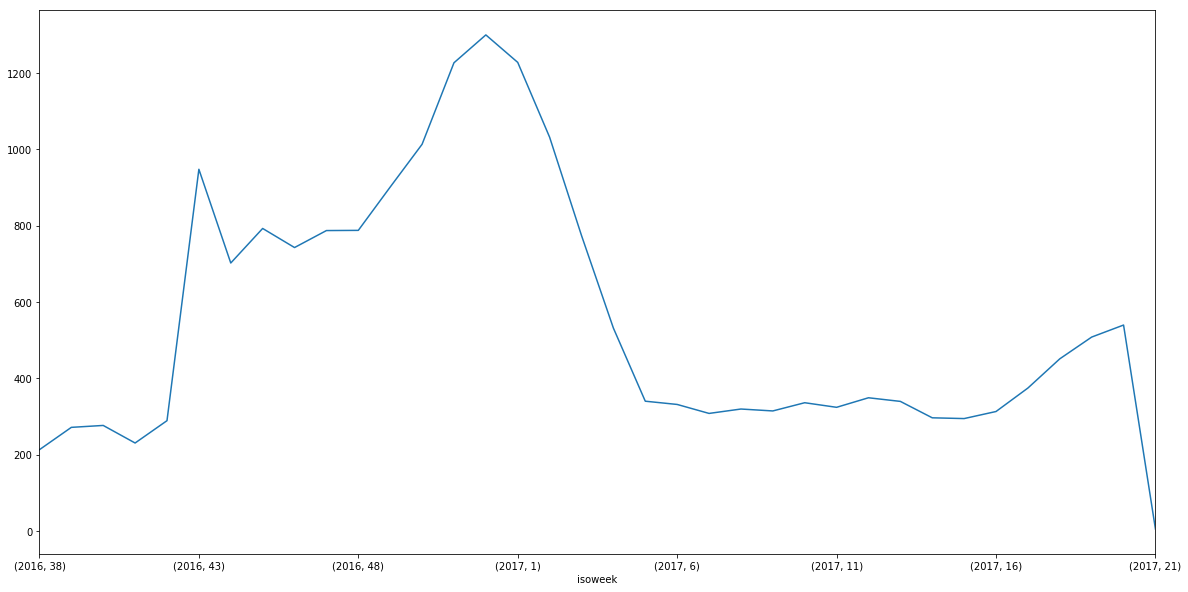

In [86]:
warehouse_median_usage.groupby(['isoweek'])['rutf_out'].sum().plot(figsize=(20,10))

In [83]:
# list of most recent stock reports from states
state_df = wh.query('siteid<40').query('siteid>1').query('weeknum<22 & year==2017')
state_df = state_df.sort_values(by=['year', 'weeknum'], ascending=[0,0])
state_df = state_df.drop_duplicates(subset='siteid')

all_states = pd.read_sql_query("select * from first_admin;", con=engine)

merge_states =pd.merge(left = all_states, right = state_df, left_on = 'state_num', right_on = 'siteid', how = 'outer')
#merge_states

In [84]:
for index, row in merge_states.iterrows():
    print row['state'],\
      int(row['weeknum']) if row['weeknum']==row['weeknum'] else "No Data",\
      "{:,}".format(int(row['rutf_bal'])) if row['rutf_bal']==row['rutf_bal'] else "No Data"
    print '---------------------'
    
# TERNARY OPERATOR condition_is_true if condition else condition_is_false

ADAMAWA 17 6,398
---------------------
BAUCHI No Data No Data
---------------------
BORNO 17 2,013
---------------------
GOMBE 18 4,032
---------------------
JIGAWA 15 50
---------------------
KADUNA 20 2,930
---------------------
KANO 20 0
---------------------
KATSINA 20 1,455
---------------------
KEBBI 20 3,490
---------------------
SOKOTO 20 1,720
---------------------
YOBE 20 7,686
---------------------
ZAMFARA 20 4,714
---------------------


In [285]:
# list of most recent stock reports from LGA

# Choose state
choose_state = 35

# Query to select one state
lga_df = wh
lga_df = lga_df.query('siteid<3999').query('siteid>101').query('weeknum<22 & year==2017')
lga_df = lga_df.sort_values(by=['year', 'weeknum'], ascending=[0,0]).drop_duplicates(subset='siteid')
# lga_df 
# Take contacts list and select those LGAs with program instead of second_admin
# if any reporter registers at a site in a LGA, then the LGA will be included even if 
# there are no supervision personnel registed at LGA
all_program_lgas = pd.read_sql_query("select * from registration;", con=engine)
all_program_lgas = all_program_lgas.query('state_num==%s' % choose_state)
all_program_lgas = all_program_lgas.sort_values(by=['lga_num', 'siteid'], ascending=[1,1])\
    .drop_duplicates(subset='lga_num')
# merge warehouse and lga data
merge_lga =pd.merge(left = all_program_lgas, right = lga_df, left_on = 'lga_num', right_on = 'siteid' , how = 'outer', sort = False)
#merge_lga
# Data Cleaning
merge_lga['lga_num'] = pd.to_numeric(merge_lga['lga_num'], errors='coerce')
merge_lga = merge_lga.query('lga_num==lga_num')

merge_lga['lga_num'] = merge_lga['lga_num'].astype('int')
merge_lga = merge_lga.query('lga_num>=200')

# Add site name from postgres
merge_lga.loc[:,'lga'] = merge_lga['lga_num'].map(lambda x: Second_admin.objects.get(lga_num=x).lga.strip() + " LGA" if Second_admin.objects.filter(lga_num=x) else "")
# Table
for index, row in merge_lga.iterrows():
    print row['lga'],\
      int(row['weeknum']) if row['weeknum']==row['weeknum'] else "No Data",\
      int(row['year']) if row['year']==row['year'] else "No Data",\
      "{:,}".format(int(row['rutf_bal'])) if row['rutf_bal']==row['rutf_bal'] else "No Data"
    print '---------------------'
    

BADE LGA 19 2017 300
---------------------
BUSARI LGA 10 2017 0
---------------------
DAMATURU LGA No Data No Data No Data
---------------------
FIKA LGA No Data No Data No Data
---------------------
FUNE LGA 6 2017 0
---------------------
GEIDAM LGA 16 2017 320
---------------------
GUJBA LGA 14 2017 10
---------------------
GULANI LGA No Data No Data No Data
---------------------
JAKUSKO LGA 17 2017 10
---------------------
KARASUWA LGA 15 2017 28
---------------------
MACHINA LGA 9 2017 515
---------------------
NANGERE LGA 19 2017 360
---------------------
NGURU LGA 16 2017 0
---------------------
POTISKUM LGA No Data No Data No Data
---------------------
TARMUWA LGA No Data No Data No Data
---------------------
YUNUSARI LGA No Data No Data No Data
---------------------
YUSUFARI LGA 4 2017 95
---------------------


In [282]:
# Min and Max of lga_num
all_program_lgas = pd.read_sql_query("select * from registration;", con=engine)

print all_program_lgas['lga_num'].min(axis=0)
print all_program_lgas['lga_num'].max(axis=0)

# all_program_lgas = all_program_lgas.query('state_num==%s & siteid>200 & siteid<3700' % choose_state)
# there is no reason to include the min and max in the query.  Just keep the database clean

101.0
3613.0


In [301]:
lga_num_min = all_program_lgas['lga_num'].min(axis=0)
print lga_num_min
#in Pandas, local variables must be referred to explicitly
all_program_lgas = all_program_lgas.query('state_num==%s & siteid>=@lga_num_min' % choose_state)

nan


In [ ]:
# REGEX

import re
choice = 33
# match objects are always true
print (re.search('[0-9]','1'))
# use bool to force a true/false response
# bool(re.search(str(choice), "33"))
# print(bool(re.search(str(choice),"33")))
x = (bool(re.search(str(choice)+'[0-9]{2}', "3311")))
print x
print "%s** == 3311 is" % choice, (bool(re.search(str(choice)+'[0-9]{2}', "3311"))) 
print "%s** == 3311 is" % choice, (bool(re.search(str(choice)+'\d\d', "3311"))) 
print "%s** == 3311 is" % choice, (bool(re.search(str(choice)+'\d{2}', "3311"))) 

In [85]:
#merge_lga['lga_num'].unique()

#map(lambda x: type(x), merge_lga['lga_num'].unique())

In [37]:
#pd.to_numeric?

#df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')

In [57]:
#merge_lga['lga'].value_counts()

# Add site name from postgres
# second_admin['sitename'] = second_admin['siteid'].map(lambda x: Second_admin.objects.get(lga_num=x).lga.strip() + " LGA" if Second_admin.objects.filter(lga_num=x) else "")

GUDU LGA            1
ILLELA LGA          1
GORONYO LGA         1
SOKOTO NORTH LGA    1
SABON BIRNI LGA     1
GADA LGA            1
SOKOTO SOUTH LGA    1
WAMAKKO LGA         1
TANGAZA LGA         1
BINJI LGA           1
Name: lga, dtype: int64

In [75]:
# Most recent stock report - LGA 
# select one LGA
site_df = df.query('lga_num==201')

site_df = site_df.query('siteid>201000000').query('weeknum<22 & year==2017')
site_df['rutf_bal'] = site_df['rutf_bal_carton'] + (site_df['rutf_bal_sachet']/150)

# Must add in most recent reports for stabilzation centers also
site_df = site_df.query('type=="OTP"')

# SORT & DROP 
site_df = site_df.sort_values(by=['year', 'weeknum', 'type'], ascending=[0,0,0])
site_df = site_df.drop_duplicates(subset=['siteid', 'type'])

In [81]:
# Add site name from postgres
site_df.loc[:,'sitename'] = site_df['siteid'].map(lambda x: Site.objects.get(siteid=x)\
                        .sitename.strip() if Site.objects.filter(siteid=x) else "")
    
# site_df['sitename'].value_counts()

In [82]:
for index, row in site_df.iterrows():
    print row['sitename'],\
      int(row['weeknum']) if row['weeknum']==row['weeknum'] else "No Data",\
      int(row['year']) if row['year']==row['year'] else "No Data",\
      "{:,}".format(int(row['rutf_bal'])) if row['rutf_bal']==row['rutf_bal'] else "No Data"
    print '---------------------'

NEW DEMSA HEALTH CLINIC 20 2017 26
---------------------
DONG  HEALTH CLINIC 18 2017 32
---------------------
KPASHAM MAT. CLINIC 17 2017 16
---------------------
MBULA MAT. HEALTH CLINIC 12 2017 16
---------------------
BILLE  MATERNITY CLINIC 12 2017 2
---------------------


In [206]:
# Number formatting - https://docs.python.org/3/library/string.html#format-specification-mini-language
print "{:,}".format(1234456)

1,234,456


NameError: name 'f' is not defined

In [134]:
a = all_states.loc(i)

In [138]:
a.ndim

2

In [ ]:
for row in all_states: 
    print(all_states['state'], 'weeknum', 'rutf_bal')

In [113]:
state_df = state_df.sort_values(by=['year', 'weeknum'], ascending=[0,0])
state_df = state_df.drop_duplicates(subset='siteid')

state_df = state_df.sort_values(by=['siteid'], ascending=[1])
# don't forget to clean data 
state_df
 # (['A', 'B'], ascending=[1, 0])

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,year,rutf_in,rutf_out,rutf_bal
3210,353333565,40bafd92-b832-48ad-b5b0-fc6ce6a25d60,+2349074642972,Roberto Acer.,,1,2016-10-30 13:27:19.231599+01:00,2016-10-30 13:28:19.864851+01:00,43,2016,0.0,57743.0,0.0
183,464087026,bf5f55a3-ee55-4429-b91d-3ea51978bd37,+2347032853473,Wullanga Alfred,,2,2017-05-02 13:47:35.188252+02:00,2017-05-02 14:08:27.184932+02:00,17,2017,0.0,410.0,6398.0
146,466204976,9b79cbdb-c498-4e86-850d-573b311a7095,+2348065476174,Hassana Suleiman Jibrin.,,8,2017-05-06 10:07:12.399795+02:00,2017-05-06 10:14:40.366241+02:00,17,2017,500.0,986.0,2013.0
58,466681285,6afd0807-35a0-4707-8f9c-52bd137fd5fe,+2348080440504,Ibrahim Inuwa Lano.,,16,2017-05-11 14:40:52.866226+02:00,2017-05-11 14:44:41.415694+02:00,18,2017,0.0,350.0,4032.0
486,458609385,37ee5714-c143-45d7-8b19-81146bb69d21,+2348065921417,Musa Mohammed Hadejia .,,17,2017-04-18 12:15:15.899269+02:00,2017-04-18 12:18:32.234389+02:00,15,2017,0.0,200.0,50.0
4010,472670971,1b162798-c149-4a25-bf4e-5f8b7ad5e15b,+2349077197415,Saratu Aduwak.,,18,2017-05-22 12:10:37.321730+02:00,2017-05-22 12:12:57.054866+02:00,20,2017,0.0,500.0,2930.0
2699,472667224,62cc7e34-1bac-4132-b274-1df87f74a20b,+2348064722797,Akilu Sani.,,19,2017-05-22 06:58:07.792443+02:00,2017-05-22 07:00:07.328223+02:00,20,2017,0.0,0.0,0.0
3765,472670198,3c92f5fe-5dc5-48a0-9905-81bfc2e52df5,+2348034677471,Hamisu Idris K/bai.,,20,2017-05-22 11:14:46.629939+02:00,2017-05-22 11:16:57.776415+02:00,20,2017,0.0,345.0,1455.0
2740,472658217,2af2c086-9a97-485f-9244-12b0b37bb12b,+2347039678456,Abdulmalik Muhammad Illo .,,21,2017-05-21 17:20:19.729168+02:00,2017-05-21 17:24:16.769879+02:00,20,2017,0.0,120.0,3490.0
3801,407945703,70d83c23-7271-420d-8a3a-67f28ad579bd,+2348069015170,Hassan Muhammad Galadanci.,,33,2017-01-09 11:55:19.697723+01:00,2017-01-09 11:59:26.770474+01:00,42,2017,0.0,100.0,2776.0
